In [1]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [2]:
batch_1 = unpickle('cifar-10-batches-py/data_batch_1')

In [3]:
X_train = batch_1['data']
X_train.shape

(10000, 3072)

In [4]:
Y_train = batch_1['labels']
len(Y_train)

10000

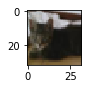

In [5]:
import matplotlib.pyplot as plt
import scipy
import scipy.misc
%matplotlib inline
import numpy as np
%matplotlib inline
plt.figure(figsize =(1,1))
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (32,32)) 
plt.imshow(image)

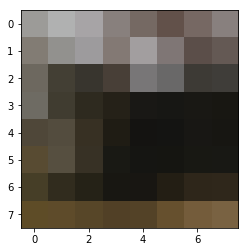

In [6]:
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (8,8)) 
plt.imshow(image)

In [7]:
def leaky_relu_and_bn(X, bn_name, alpha=0.3):
    X = tf.layers.batch_normalization(X, name=bn_name)
    return tf.nn.relu(X) - alpha * tf.nn.relu(-X)

In [8]:
import tensorflow as tf
tf.reset_default_graph()

In [9]:
# Discriminator
# -----
# Phase: 0 (initial)
# Input: 3 x 4 x 4

# Block: from_rgb_4
# c1 (from_rbg): 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# -----
# Phase: 1 (add 1)
# Input: 3 x 8 x 8

# Block: from_rgb_8
# c1 (from_rbg): 64 x 8 x 8

# Block: added_8_to_4
# c3: 64 x 8 x 8
# c3: 128 x 8 x 8
# dn: 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# -----
# Phase: 2 (add 2)
# Input: 3 x 16 x 16

# Block: from_rgb_16
# c1 (from_rbg): 32 x 16 x 16

# Block: added_16_to_8
# c3: 32 x 16 x 16
# c3: 64 x 16 x 16
# dn: 64 x 8 x 8

# Block: added_8_to_4
# c3: 64 x 8 x 8
# c3: 128 x 8 x 8
# dn: 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# -----
# Phase: 3 (add 3)
# Input: 3 x 32 x 32

# Block: from_rgb_32
# c1 (from_rbg): 16 x 32 x 32

# Block: added_32_to_16
# c3: 16 x 32 x 32
# c3: 32 x 32 x 32
# dn: 32 x 16 x 16

# Block: added_16_to_8
# c3: 32 x 16 x 16
# c3: 64 x 16 x 16
# dn: 64 x 8 x 8

# Block: added_8_to_4
# c3: 64 x 8 x 8
# c3: 128 x 8 x 8
# dn: 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# ><><><><><><><><><><><><

# Generator
# ------
# Phase: Initial
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: to_rgb_4
# c1 (to_rgb): 3 x 4 x 4

# ----
# Phase: add 1
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: added_4_to_8
# up: 128 x 8 x 8
# c3: 64 x 8 x 8
# c3: 64 x 8 x 8

# Block: to_rgb_8
# c1 (to_rgb): 3 x 8 x 8

# -----
# Phase: add 2
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: added_4_to_8
# up: 128 x 8 x 8
# c3: 64 x 8 x 8
# c3: 64 x 8 x 8

# Block: added_8_to_16
# up: 64 x 16 x 16
# c3: 32 x 16 x 16
# c3: 32 x 16 x 16

# Block: to_rgb_16
# c1 (to_rgb): 3 x 16 x 16

# ----
# Phase: add 3
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: added_4_to_8
# up: 128 x 8 x 8
# c3: 64 x 8 x 8
# c3: 64 x 8 x 8

# Block: added_8_to_16
# up: 64 x 16 x 16
# c3: 32 x 16 x 16
# c3: 32 x 16 x 16

# Block: added_16_to_32
# up: 32 x 32 x 32
# c3: 16 x 32 x 32
# c3: 16 x 32 x 32

# Block: to_rgb_32
# c1 (to_rgb): 3 x 32 x 32

In [10]:
# Config:
batch_size = 32
num_images_before_adding_block_constant = 1600000
max_num_blocks_to_add = 3

In [11]:
def calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen):
    num_images_before_adding_block = tf.constant(num_images_before_adding_block_constant)
    num_blocks_to_add = tf.cast(tf.floor(tf.divide(num_images_seen, num_images_before_adding_block)))
    r = tf.subtract(num_images_seen, tf.multiply(num_blocks_to_add, num_images_before_adding_block))
    
    smoothing_coefficient = tf.cond(num_blocks_to_add >= tf.constant(max_num_blocks_to_add), lambda: tf.constant(1), lambda: tf.minimum(
        tf.constant(1), tf.divide(r, tf.divide(num_images_before_adding_block, tf.constant(2)))))
    num_blocks_to_add = tf.minimum(num_blocks_to_add, tf.constant(max_num_blocks_to_add))
    
    return [num_blocks_to_add, smoothing_coefficient]

In [12]:
def leaky_relu_and_bn(X, bn_name, alpha=0.3):
    X = tf.layers.batch_normalization(X, name=bn_name)
    return tf.nn.relu(X) - alpha * tf.nn.relu(-X)

In [13]:
# In: batch_size, resolution, resolution, 3
# Out: batch_size, resolution, resolution, target_num_channels 
def from_rgb(X, resolution, target_num_channels, reuse=None):
    with tf.variable_scope("from_rgb_" + resolution):
        if (reuse): #TODO: Need reuse?
            tf.get_variable_scope().reuse_variables()
        X_normalized = tf.layers.batch_normalization(X, name='bn0' + str(resolution))
        w = tf.get_variable('w' + str(resolution), [1, 1, 3, target_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / target_num_channels)))
        b = tf.get_variable('b' + str(resolution), [target_num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.nn.conv2d(X_normalized, w, [1,1,1,1], padding='SAME') + b
        return leaky_relu_and_bn(conv, 'bn1' + str(resolution))

In [14]:
# In: batch_size, 4*2^phase, 4*2^phase, 3
# Out: batch_size, 4*2^phase, 4*2^phase, 128/(2^phase)
def from_rgb_for_phase(X, phase, reuse=None):
    return tf.case([
            (tf.equal(phase, tf.constant(0)), lambda: from_rgb(X, 4, 128, reuse)),
            (tf.equal(phase, tf.constant(1)), lambda: from_rgb(X, 8, 64, reuse)),
            (tf.equal(phase, tf.constant(2)), lambda: from_rgb(X, 16, 32, reuse)),
            (tf.equal(phase, tf.constant(3)), lambda: from_rgb(X, 32, 16, reuse)),
        ], default=lambda: tf.zeros((1,4,4,128)))

In [15]:
# In: batch_size, 4*2^phase, 4*2^phase, 3
# Out: batch_size, 4*2^phase, 4*2^phase, 128/(2^phase) 
def from_rgb_possibly_smoothed(X, phase):
    from_rgb = from_rgb_for_phase(X, phase)
    if (smoothing_coefficient < 1):
        half_resolution_X = tf.nn.avg_pool(X, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')
        prior_from_rgb = from_rgb_for_phase(half_resolution_X, phase - 1)
        return (1 - smoothing_coefficient) * prior_from_rgb + smoothing_coefficient * from_rgb
    else: 
        return from_rgb

In [16]:
# In: batch_size, input_resolution, input_resolution, input_num_channels
# Out: batch_size, input_resolution / 2, input_resolution / 2, 2 * input_num_channels
def added_discriminator_block(X, input_resolution, input_num_channels):
    target_resolution = input_resolution / 2
    target_num_channels = 2 * input_num_channels
    with tf.variable_scope("added_block_" + str(input_resolution) + "_to_" + str(target_resolution)):
        w1 = tf.get_variable('w1', [3, 3, input_num_channels, input_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / input_num_channels)))
        b1 = tf.get_variable('b1', [input_num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv1 = tf.nn.conv2d(X, w1, [1,1,1,1], padding='SAME', name='conv1') + b1
        a1 = leaky_relu_and_bn(conv1, 'bn1')

        w2 = tf.get_variable('w2', [3, 3, input_num_channels, target_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / input_num_channels)))
        b2 = tf.get_variable('b2', [target_num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv2 = tf.nn.conv2d(a1, w2, [1,1,1,1], padding='SAME', name='conv2') + b2
        a2 = leaky_relu_and_bn(conv_2, 'bn2')  

        return tf.nn.avg_pool(a2, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')

In [17]:
# In: batch_size, 4, 4, 128
# Out: batch_size, 1, 1, 1
def discriminator_output_block(X):
    with tf.variable_scope("output_block"):
        w1 = tf.get_variable('w1', [3, 3, 128, 128], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 128)))
        b1 = tf.get_variable('b1', [128], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv1 = tf.nn.conv2d(X, w1, [1,1,1,1], padding='SAME') + b1
        a1 = leaky_relu_and_bn(conv1, 'bn1')

        w2 = tf.get_variable('w2', [4, 4, 128, 128], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 128)))
        b2 = tf.get_variable('b2', [128], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv2 = tf.nn.conv2d(a1, w2, [1,1,1,1], padding='VALID') + b2
        a2 = leaky_relu_and_bn(conv2, 'bn2')
        return tf.layers.dense(a2, 1)

In [18]:
# In: batch_size, 4*2^phase, 4*2^phase, 3
# Out: batch_size, 1, 1, 1
def discriminator(X, num_images_seen, reuse=False):
    with tf.variable_scope("D"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        num_blocks_to_add, smoothing_coefficient = calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen)
        phase = num_blocks_to_add
        
        X = from_rgb_possibly_smoothed(X, phase)
        
        X = tf.cond(phase >= 3, added_discriminator_block(32, 16), X)
        X = tf.cond(phase >= 2, added_discriminator_block(16, 32), X)
        X = tf.cond(phase >= 1, added_discriminator_block(8, 64), X)

        return discriminator_output_block(X)

In [19]:
def generator(z, num_images_seen, batch_size, reuse=False):
    with tf.variable_scope("G"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        num_blocks_to_add, smoothing_coefficient = calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen)
